In [29]:
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('mols/scans/dingerxi/6-311G.txt','r',encoding='utf-8') as f:
    content=f.read()

In [59]:
def get_order(content,a1,a2):
    res=re.findall(f'{a1}-{a2},'+r'BO:(-?\d.\d+),BL:(-?\d.\d+)',content)[0]
    return res

In [64]:
def get_orders(contents,a1,a2):
    orders=[]
    bondls=[]
    for content in contents:
        order,bondl=get_order(content,a1,a2)
        orders.append(order)
        bondls.append(bondl)
    orders=np.array(orders,dtype=float)
    bondls=np.array(bondls,dtype=float)
    return orders,bondls

Text(0.5, 1.0, '$C_4-C_6$ Bond Length')

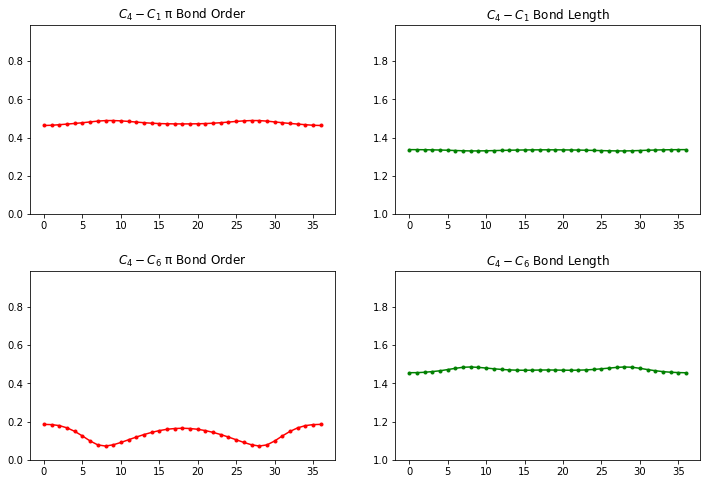

In [75]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
orders,bondls=get_orders(contents,4,1)
ax[0,0].plot(np.arange(len(orders)),orders,'.-r')
ax[0,0].set_ylim(0,.99)
ax[0,0].set_title('$C_4-C_1$ π Bond Order')
ax[0,1].plot(np.arange(len(bondls)),bondls,'.-g')
ax[0,1].set_ylim(1,1.99)
ax[0,1].set_title('$C_4-C_1$ Bond Length')
orders,bondls=get_orders(contents,4,6)
ax[1,0].plot(np.arange(len(orders)),orders,'.-r')
ax[1,0].set_ylim(0,.99)
ax[1,0].set_title('$C_4-C_6$ π Bond Order')
ax[1,1].plot(np.arange(len(bondls)),bondls,'.-g')
ax[1,1].set_ylim(1,1.99)
ax[1,1].set_title('$C_4-C_6$ Bond Length')
# plt.savefig('dingerxi.png',dip=300,bbox_inches='tight')

## 自由基与乙烯反应的势能

In [1]:
import sys
sys.path.append('D:\code\pywfn')
sys.path

['D:\\BaiduSyncdisk\\Articles\\HFV',
 'D:\\programs\\anaconda3\\python39.zip',
 'D:\\programs\\anaconda3\\DLLs',
 'D:\\programs\\anaconda3\\lib',
 'D:\\programs\\anaconda3',
 '',
 'D:\\programs\\anaconda3\\lib\\site-packages',
 'D:\\programs\\anaconda3\\lib\\site-packages\\win32',
 'D:\\programs\\anaconda3\\lib\\site-packages\\win32\\lib',
 'D:\\programs\\anaconda3\\lib\\site-packages\\Pythonwin',
 'D:\\code\\pywfn']

In [2]:
import pywfn
from pywfn.readers import LogReader
from pywfn.bondorder import piDM
import numpy as np

In [3]:
orders=[]
bls=[]
ERs=[]
for i in range(4):
    reader=LogReader(rf"D:\BaiduSyncdisk\gFile\reaction2\CF{i}.log")
    mol=reader.mol
    caler=piDM.Calculator(mol)
    order1=caler.calculate(mol.atom(1),mol.atom(2))
    order2=caler.calculate(mol.atom(1),mol.atom(5))
    order3=caler.calculate(mol.atom(1),mol.atom(7))
    orders.append([order1,order2,order3])
    bl1=mol.bond(1,2).length
    bl2=mol.bond(1,5).length
    bl3=mol.bond(1,7).length
    bls.append([bl1,bl2,bl3])
    ERs.append(mol.E)

重构密度矩阵: 100%|██████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 8140.40it/s]


In [4]:
orders

[[0.2971064396510175, 0.29712719252578945, 0.2971149575314283],
 [0.2776349104317625, 0.33232290602249265, 0.27763942204195885],
 [0.25974077214326474, 0.31433732989274976, 0.3143903706599987],
 [0.2994187051032419, 0.27622361531609146, 0.26909047685175236]]

In [5]:
bls

[[1.4976761838084358, 1.497662033455479, 1.4976698082087383],
 [1.4968808010052101, 1.4864050362014387, 1.496880654433078],
 [1.494361000533004, 1.488596027591435, 1.488587292909959],
 [1.4861584361009426, 1.491197410994936, 1.4932186090529411]]

In [7]:
ERs

[-157.710538, -256.945084, -356.177109, -455.409665]

In [10]:
os=1.6494416218465484-np.array(orders).sum(axis=1)
os

array([0.75809303, 0.76184438, 0.76097315, 0.80470882])

In [11]:
ETs=[]
for i in range(4):
    reader=LogReader(rf"D:\BaiduSyncdisk\gFile\reaction2\CF{i}_TS.log")
    mol=reader.mol
    ETs.append(mol.E)
ETs

[-236.237738, -335.472642, -434.705524, -533.942737]

In [12]:
E0=LogReader(r'D:\BaiduSyncdisk\gFile\reaction2\CH2=CH2.log').mol.E
es=np.array(ETs)-np.array(ERs)-E0

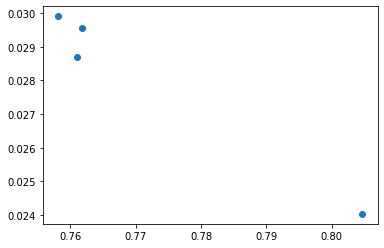

In [13]:
import matplotlib.pyplot as plt
plt.scatter(os,es)

In [14]:
es

array([0.029908, 0.02955 , 0.028693, 0.024036])

## 尝试在QM9数据集中找到相同Mulliken 电荷的C原子

In [44]:
root='D:\数据库\QM9\dsgdb9nsd.xyz'
from pathlib import Path
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys

In [11]:
root=Path(root)

In [52]:
def get_anums(cords):
    """判断原子连接原子个数"""
    c1=np.repeat(cords[:,:,None],repeats=len(cords),axis=2)
    c2=c1.transpose(2,1,0)
    dis=np.linalg.norm(c2-c1,axis=1)
    nums=((dis>0)*(dis<1.7)).sum(axis=0) #每个原子相邻原子的个数
    return nums
def get_data(path:Path):
    text=path.read_text()
    lines=text.splitlines(keepends=False)
    na=int(lines[0])
    res=[]
    for i in range(2,na+2):
        line=lines[i]
        res.append(line.replace('*^','e').split('\t'))
    res=np.array(res)
    cords=res[:,1:4].astype(np.float32) #原子坐标矩阵 n,3
    atoms=res[:,0] #原子符号 n
    elect=res[:,4].astype(np.float32) # 原子电荷 n
    anums=get_anums(cords) # 每个原子相邻原子个数
    if len(res)!=na:
        print(path)
        for each in res:
            print(each)
        raise f'匹配不完全'
    return atoms,elect,anums
def get_energy(molID:str):
    """获取分子的能量"""
    text=Path(f'D:\数据库\QM9\dsgdb9nsd.xyz\dsgdb9nsd_{molID}.xyz').read_text()
    lines=text.splitlines(keepends=False)
    data=lines[1].split('\t')
    return data[13]

### 获取所有sp2 C 与SP3 C 的电荷，并保存到文件中，以减少内存的占用

In [17]:
for i,path in enumerate(root.iterdir()):
    path_= Path(f'QM9/{(i+1):0>6}.txt')
    
    atoms,elect,anums=get_data(path) # 元素符号，电荷数，相邻原子数
    if 'F' in atoms:continue # 排除带原子的分子
    sp2_idxs=np.argwhere((atoms=='C')*(anums==3)).flatten() # sp2 c，分子中满足条件的原子索引
    sp3_idxs=np.argwhere((atoms=='C')*(anums==4)).flatten() # sp3 c
    if len(sp2_idxs)==0 and len(sp3_idxs)==0:continue # 如果既没有sp2也没有sp3 C，就排除该分子
    res_str=''
    sp2_elec=elect[sp2_idxs]
    sp3_elec=elect[sp3_idxs]
    
    all_idxs=np.unique(np.concatenate([sp2_idxs,sp3_idxs],axis=0)) # 拼接并去重
    all_mols=np.ones_like(all_idxs)*(i+1) #分子索引
    
    atomid=all_idxs
    elects=elect[all_idxs]
    arnums=anums[all_idxs]
    
    atomic,atonum=np.unique(atoms,return_counts=True) #元素符号及数量统计
    n_C=np.sum(atoms=='C')
    n_H=np.sum(atoms=='H')
    n_O=np.sum(atoms=='O')
    n_N=np.sum(atoms=='N')
    expres=f'C{n_C}H{n_H}O{n_O}N{n_N}'
    
    res_str+=f'{expres}\n{atomid}\n{elects}\n{arnums}\n{sp2_idxs}\n{sp2_elec}\n{sp3_idxs}\n{sp3_elec}'
    path_.write_text(res_str) #用以查询每个分子的sp2和sp3的原子及电荷
    
    pnum=int(i/133885*100)
    print(f'\r{i+1}/133885  {i/133885}',end="")

133885/133885

### 重新读取数据
- 同分异构体及数量
- 分子id，sp2原子id以及其电荷

In [45]:
molids=''
atomid=''
elects=''
expers={}
for i,path in tqdm(enumerate(Path('QM9').iterdir())):
    if i==0:continue
    lines=path.read_text().splitlines(keepends=False)
    exper=lines[0]
    sp2_idxs=lines[4][1:-1]
    sp2_elec=lines[5][1:-1]
    if len(sp2_idxs)==0:continue
    if exper not in expers.keys():expers[exper]=[]
    expers[exper].append(path.name)
    atomid+=f'{sp2_idxs} '
    elects+=f'{sp2_elec} '
    num=len(sp2_idxs.split(' '))
    molids+=f'{path.stem} '*num
#     if i>200:break

131707it [10:28, 209.45it/s]


In [46]:
molids=np.fromstring(molids,sep=' ',dtype=int)
atomid=np.fromstring(atomid,sep=' ',dtype=int)
elects=np.fromstring(elects,sep=' ',dtype=float)

In [48]:
len(expers) #同分异构体的数量

394

In [65]:
biass=[]
for i,(key,value) in enumerate(expers.items()):
    if len(value)<5:continue
    if len(value)>20:continue
    molIDs=[each[:6] for each in value]
    engs=np.array([get_energy(molID) for molID in molIDs],dtype=float)
    bias=np.sum((engs-engs.mean())**2)/len(engs)
    bias=engs.max()-engs.min()
    biass.append(bias)
    print(i,key,len(engs),bias)

10 C3H7O1N1 7 0.07316500000001724
14 C3H3O1N1 5 0.03511299999999551
15 C2H3O0N3 5 0.025517000000007783
20 C3H6O2N0 6 0.04801799999995637
23 C3H5O1N1 6 0.0413780000000088
29 C3H7O2N1 13 0.09580099999999447
30 C4H9O1N1 13 0.0747000000000071
32 C3H6O1N2 12 0.12760400000001937
33 C3H5O2N1 18 0.1306170000000293
35 C3H3O2N1 9 0.05648500000000922
38 C5H6O1N0 14 0.0947840000000042
39 C4H6O0N2 8 0.02436699999998382
40 C3H5O0N3 16 0.035043999999970765
45 C5H10O1N0 7 0.014726999999993495
46 C4H8O2N0 16 0.05131299999999328
51 C5H8O1N0 13 0.04558500000001686
57 C4H4O2N0 7 0.03160600000001068
58 C3H4O3N0 7 0.05621800000000121
63 C2H4O0N4 8 0.045341000000007625
64 C2H3O1N3 12 0.08688099999994847
80 C5H3O1N1 17 0.16167500000000246
82 C6H9O0N1 18 0.15225700000002007
89 C4H4O3N0 17 0.1300200000000018
90 C3H3O3N1 11 0.04934000000002925
93 C3H4O0N4 15 0.11689900000004627
98 C3H2O2N2 15 0.11924899999996796
99 C7H8O0N0 9 0.1794079999999667
100 C6H7O0N1 9 0.15675200000003997
101 C5H6O0N2 11 0.084316999999998

In [67]:
max(biass),biass.index(max(biass))

(0.2504500000000007, 59)

In [68]:
expers['C2H1O3N3']

['021429.txt',
 '021441.txt',
 '021445.txt',
 '021820.txt',
 '021849.txt',
 '021875.txt',
 '021977.txt',
 '021980.txt',
 '021981.txt',
 '021986.txt',
 '021987.txt']

In [70]:
engs=[get_energy(exper[:6]) for exper in expers['C2H1O3N3']]
engs

['-466.616318',
 '-466.607625',
 '-466.561735',
 '-466.633961',
 '-466.595344',
 '-466.755368',
 '-466.521026',
 '-466.526753',
 '-466.539168',
 '-466.542058',
 '-466.504918']

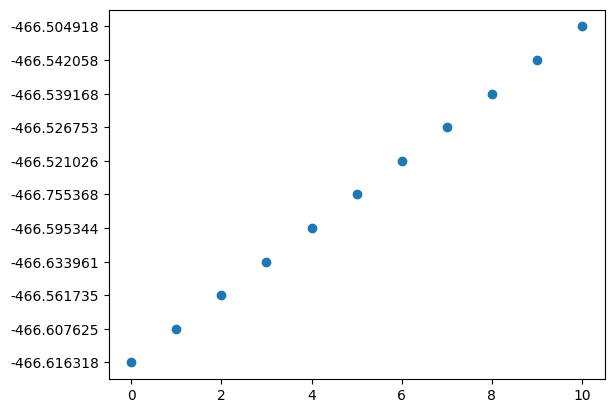

In [73]:
plt.scatter(list(np.arange(len(engs))),engs)

### 查看分子的原子数量以及sp2,sp3分布

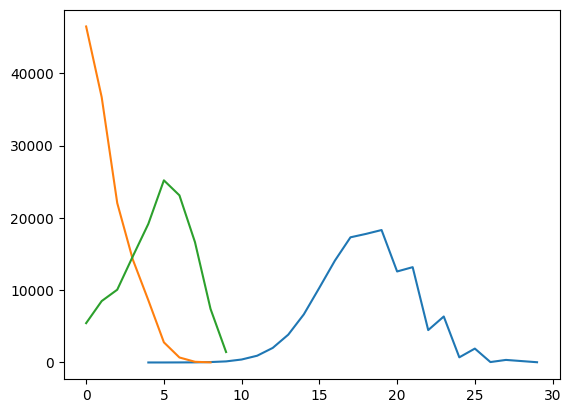

In [97]:
xs,ys=np.unique(np.array(atomNums),return_counts=True)
plt.plot(xs,ys)
xs,ys=np.unique(np.array(sp2_anum),return_counts=True)
plt.plot(xs,ys)
xs,ys=np.unique(np.array(sp3_anum),return_counts=True)
plt.plot(xs,ys)

### 查看SP2和SP3电荷分布

(1138, 1143)

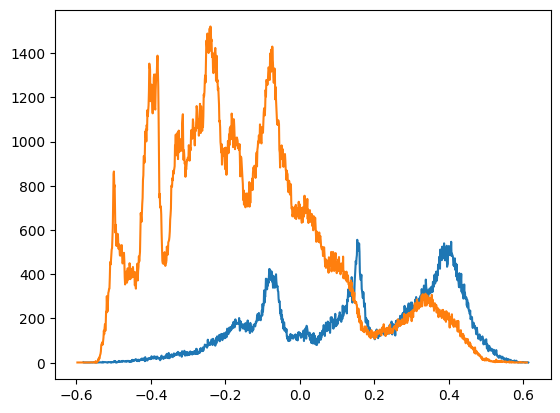

In [81]:
xs2,ys2=np.unique(sp2_elec.round(3),return_counts=True)
plt.plot(xs2,ys2)
xs3,ys3=np.unique(sp3_elec.round(3),return_counts=True)
plt.plot(xs3,ys3)
len(xs2),len(xs3)

### 找到相同电荷对应的分子

In [99]:
sp2_elec_round=sp2_elec.round(3) #保留后四位小数
sp2_elec_unique=np.unique(sp2_elec_round) #去重

sp3_elec_round=sp3_elec.round(3) #保留后四位小数
sp3_elec_unique=np.unique(sp3_elec_round) #去重

len(sp2_elec_unique),len(sp3_elec_unique),sp2_elec_unique.min(),sp2_elec_unique.max(),sp3_elec_unique.min(),sp3_elec_unique.max()

(1138, 1143, -0.581, 0.613, -0.597, 0.609)

In [106]:
sp2_aidx[26321],sp2_elec[np.argwhere(sp2_mols==26322)]

(array([3, 4, 6], dtype=int64),
 array([[ 0.27351299],
        [-0.149039  ],
        [ 0.46784201]]))

## 计算丁二烯扫描pi电子变化